# Active learning with GPflow

## Import modules

In [1]:
# General python 
import pandas as pd
import numpy as np
import random

# Plotting
import matplotlib.pyplot as plt

# Machine learning training & prediction
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from active_learning import *

2024-03-26 10:42:07.747465: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 10:42:08.989110: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
plt.style.use('seaborn-v0_8-bright')

## Load data

In [3]:
df = pd.read_csv('../data/qm9_ecfp4_sample.csv', index_col=0)

## Initial model

In [4]:
sample = df.sample(n=50)
# Split into input, X, and output, y
X_sample = sample[ sample.columns[:-2] ].astype(float).values
y_sample = sample[ sample.columns[-1] ].values.reshape(-1,1)

test_inds = [ind for ind in df.index if ind not in sample.index]
X_test = df.loc[ test_inds, sample.columns[:-2] ].astype(float).values
y_test = df.loc[ test_inds, sample.columns[-1] ].values.reshape(-1,1)

In [5]:
model = gpflow.models.GPR( (X_sample, y_sample), kernel=gpflow.kernels.Matern12() )
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)
y_pred, y_unc = model.predict_y(X_test)
f_pred, f_unc = model.predict_f(X_test)

2024-03-26 10:42:15.008679: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
r2_score(y_test, y_pred)

0.49250102465822077

Text(0, 0.5, 'Predicted HOMO energy')

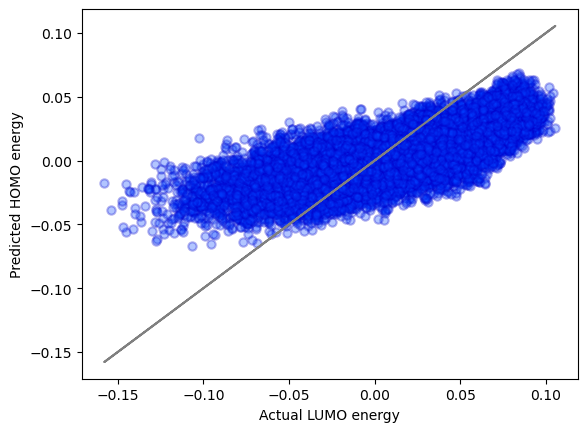

In [7]:
# Parity plot
fig,ax = plt.subplots()
scatter = ax.scatter( y_test, y_pred, alpha = 0.3, edgecolor='mediumblue', linewidth=1.5, )
parity = ax.plot( y_test, y_test, color='gray')
ax.set_xlabel("Actual LUMO energy")
ax.set_ylabel("Predicted HOMO energy")

## Active learning

In [8]:
# Split into input, X, and output, y
X = df[ df.columns[:-2] ].astype(float).values
y = df[ df.columns[-1] ].values.reshape(-1,1)

In [9]:
y_max_rand, model_rand, train_inds_rand = run(X, y, 50, 100, 10, 'random')
y_max_al, model_al, train_inds_al = run(X, y, 50, 100, 10, 'mu')

### Analysis

In [10]:
print(f'Found maximum in {len(y_max_al)} steps with active learning')

Found maximum in 28 steps with active learning


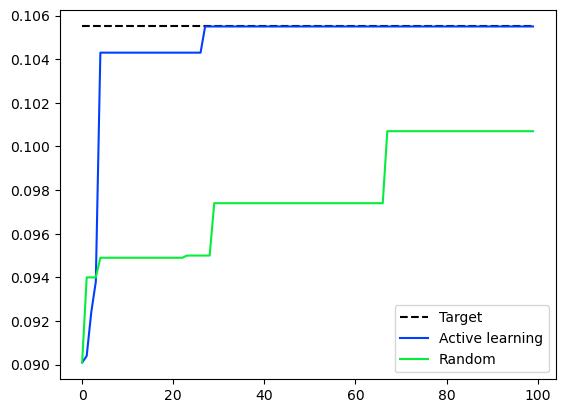

In [11]:
n_steps = 100

if len(y_max_al) < n_steps:
    y_max_al += [max(y_max_al)]*(n_steps - len(y_max_al))
if len(y_max_rand) < n_steps:
    y_max_rand += [max(y_max_rand)]*(n_steps - len(y_max_rand))
    
true_max = max(y)
fig,ax = plt.subplots()
ax.plot(range(n_steps), [true_max]*n_steps, 'k', linestyle='dashed', label='Target')
ax.plot(range(n_steps), y_max_al, label='Active learning')
ax.plot(range(n_steps), y_max_rand, label='Random')
ax.legend()

In [12]:
all_inds = set(range(len(y)))
test_inds_rand = list(all_inds.difference(train_inds_rand))
test_inds_al = list(all_inds.difference(train_inds_al))

X_test_rand = X[test_inds_rand]
y_test_rand = y[test_inds_rand]

X_test_al = X[test_inds_al]
y_test_al = y[test_inds_al]

Random R2=0.84, Active learning R2=0.48


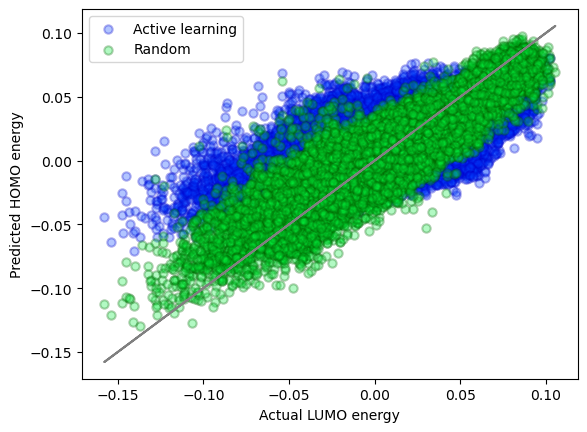

In [13]:
y_pred_rand, y_unc_rand = model_rand.predict_y(X_test_rand)
y_pred_al, y_unc_al = model_al.predict_y(X_test_al)
print(f'Random R2={round(r2_score( y_test_rand, y_pred_rand ),2)}, Active learning R2={round( r2_score(y_test_al, y_pred_al), 2)}' )

fig,ax = plt.subplots()
scatter_al = ax.scatter( y_test_al, y_pred_al, alpha = 0.3, edgecolor='mediumblue', linewidth=1.5,
                        label='Active learning' )
scatter_rand = ax.scatter( y_test_rand, y_pred_rand, alpha = 0.3, edgecolor='darkgreen', linewidth=1.5, 
                          label='Random' )
parity = ax.plot( y_test_rand, y_test_rand, color='gray')
ax.set_xlabel("Actual LUMO energy")
ax.set_ylabel("Predicted HOMO energy")
leg = ax.legend()